In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame as df
from IPython.display import display
#from pandas import set_option
#from pandas.plotting import scatter_matrix
import re
import collections

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,ShuffleSplit,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,make_scorer,fbeta_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor

#import xgboost as xgb
#from xgboost import XGBClassifier,plot_tree,plot_importance

ImportError: No module named xgboost

In [2]:
# *load data*
train_data=pd.read_csv('train.csv')

In [3]:
# *split data into X and y*
y=train_data['target'].values
X=train_data.drop(['target','id'],axis=1)

## Data Exploration
### 1) Prepare Data
Reasons for splitting data set into groups
* there're a lot of features
* some features by nature are more relevant to one another than others
* also split by data type for visualizations

In [4]:
# column names split by Individual, Car and Region
ind_col=[col for col in X.columns if '_ind_' in col]
car_col=[col for col in X.columns if '_car_' in col]
reg_col=[col for col in X.columns if '_reg_' in col]

# column names split by Binary, Categorical, Ordinal and Continuous
bin_col=[col for col in X.columns if '_bin' in col]
cat_col=[col for col in X.columns if '_cat' in col]
ord_col=[col for col in X.columns if '_cat' not in col and '_bin' not in col and np.unique(X[col]).size<100]
cont_col=[col for col in X.columns if '_cat' not in col and '_bin' not in col and np.unique(X[col]).size>=100]
num=[np.unique(X[col]).size for col in cont_col]
d = dict(zip(cont_col, num))
od = collections.OrderedDict(sorted(d.items()))
od

OrderedDict([('ps_car_12', 184),
             ('ps_car_13', 70482),
             ('ps_car_14', 850),
             ('ps_reg_03', 5013)])

In [5]:
# make dataframes for groupings identified above
X_ind=X[ind_col]
X_ind.drop(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin','ps_ind_10_bin','ps_ind_11_bin',
            'ps_ind_12_bin','ps_ind_13_bin','ps_ind_14','ps_ind_16_bin','ps_ind_17_bin','ps_ind_18_bin'],axis=1
           ,inplace=True)
#X_ind.drop(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin','ps_ind_10_bin','ps_ind_11_bin',
            #'ps_ind_12_bin','ps_ind_13_bin','ps_ind_14'],axis=1,inplace=True)
X_car=X[car_col]
X_reg=X[reg_col]
X_bin=X[bin_col]
X_cat=X[cat_col]
X_ord=X[ord_col]
X_cont=X[cont_col]

### 2) Explore Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.
In the code block below, you will need to implement the following:
* Assign new_data a copy of the data by removing a feature of your choice using the DataFrame.drop function.
* Use sklearn.cross_validation.train_test_split to split the dataset into training and testing sets.
* Use the removed feature as your target label. Set a test_size of 0.25 and set a random_state.
* Import a decision tree regressor, set a random_state, and fit the learner to the training data.
* Report the prediction score of the testing set using the regressor's score function.

In [84]:
X_ind.columns

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_15'],
      dtype='object')

In [7]:
def relevance_score(data,feature,model):
    temp_X=data.copy(deep=True)
    temp_y=df(temp_X[feature])
    temp_X.drop(feature,axis=1,inplace=True)
    X_train,X_test,y_train,y_test = train_test_split(temp_X,temp_y,test_size=0.2,random_state=88)
    model.fit(X_train,y_train)
    score=model.score(X_test,y_test)
    return score

In [9]:
for col in X_ind:
    score=relevance_score(X_ind,col,DecisionTreeClassifier())
    print col,score

ps_ind_01 0.314533403896
ps_ind_02_cat 0.765336895072
ps_ind_03 0.241593373823
ps_ind_04_cat 0.659333182127
ps_ind_05_cat 0.887225624354
ps_ind_15 0.151432675588


ps_ind_01 0.328452743966
ps_ind_02_cat 0.762858798921
ps_ind_03 0.244651092462
ps_ind_04_cat 0.656384667725
ps_ind_05_cat 0.886267987198
ps_ind_15 0.210562569828
ps_ind_16_bin 0.938896029166
ps_ind_17_bin 0.965844274758
ps_ind_18_bin 0.969532017842

### 3) Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation?
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict?
* How is the data for those features distributed?

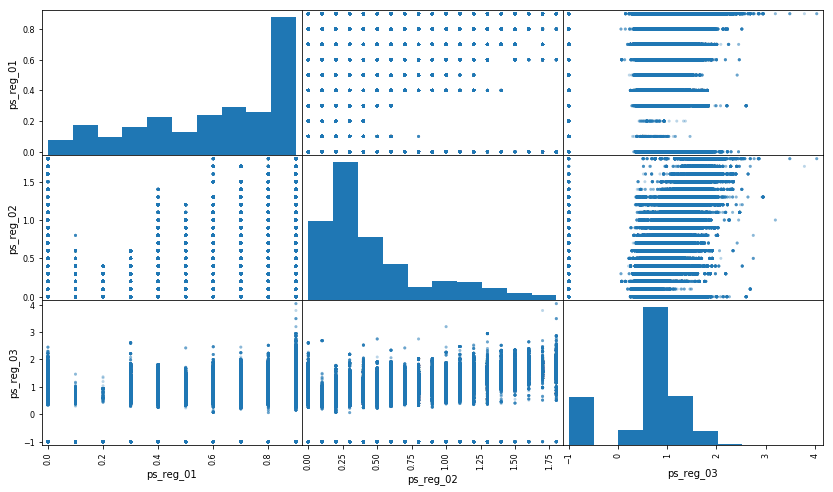

In [89]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(X_reg,alpha=0.3,figsize=(14,8),diagonal='hist');

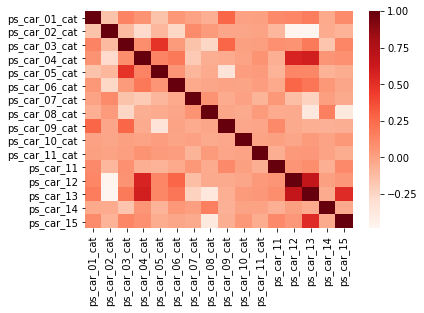

In [110]:
sb.heatmap(X_car.corr(),cmap='Reds');

In [91]:
# histograms
#X_ind.hist(layout=(12,3),figsize=(25,100)) # param 'by' can be used to form histograms for separate groups
#plt.show()

In [ ]:
#list(X['ps_ind_13_bin']).count(1)
#col=X['ps_car_13']
#np.unique(col)
#labels = train_data.groupby(col).size()
#print(labels)

In [ ]:
# density plots
#X.plot(kind='density',subplots=True,layout=(19,3),figsize=(25,50),legend=True)
#plt.show()

In [ ]:
# box plots
#X_imp.plot(kind='box',subplots=True,layout=(9,3),figsize=(25,50),legend=True)
#plt.show()

In [ ]:
# produce a scatter matrix for each pair of features in the data
#pd.plotting.scatter_matrix(X, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
#plt.show()

In [ ]:
# correlation matrix
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1)
#cax = ax.matshow(X.corr(), vmin=-1, vmax=1)
#fig.colorbar(cax)
#plt.show()

## Feature Transformation